# TG43 Testing

Copyright (C) 2016-2017 Simon Biggs

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Affero General Public License as
published by the Free Software Foundation, either version 3 of the
License, or (at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

from scipy.interpolate import RegularGridInterpolator

from copy import copy

import matplotlib.pyplot as plt
%matplotlib inline

## Loading Data

In [2]:
dose_rate_constant = np.squeeze(
    pd.DataFrame.from_csv('source_data/Lambda.csv', index_col=None, header=None).values)
dose_rate_constant

array(1.10942)

In [3]:
length = np.squeeze(
    pd.DataFrame.from_csv('source_data/L.csv', index_col=None, header=None).values)
length

array(0.35)

In [4]:
radial_function_table = pd.DataFrame.from_csv('source_data/g_L(r).csv')

radial_function_data = xr.DataArray(
    np.squeeze(radial_function_table.values),
    coords=[
        radial_function_table.index.values.astype(float)],
    dims=['radius_cm'])

radial_function_data

<xarray.DataArray (radius_cm: 18)>
array([ 1.276,  1.276,  1.199,  1.11 ,  1.018,  1.001,  0.995,  0.997,  0.998,
        1.   ,  1.003,  1.005,  1.008,  1.007,  1.003,  0.996,  0.972,  0.939])
Coordinates:
  * radius_cm  (radius_cm) float64 0.0 0.06 0.08 0.1 0.15 0.2 0.25 0.5 0.75 ...

In [5]:
anisotropy_function_table = pd.DataFrame.from_csv('source_data/F(r,theta).csv')

anisotropy_function_data = xr.DataArray(
    anisotropy_function_table.values,
    coords=[
        anisotropy_function_table.index.values.astype(float), 
        anisotropy_function_table.columns.values.astype(float)],
    dims=['theta_deg', 'radius_cm'])

anisotropy_function_data

<xarray.DataArray (theta_deg: 47, radius_cm: 20)>
array([[ 0.951,  0.951,  0.934, ...,  0.733,  0.768,  0.798],
       [ 0.947,  0.947,  0.93 , ...,  0.744,  0.775,  0.801],
       [ 0.944,  0.944,  0.927, ...,  0.755,  0.782,  0.804],
       ..., 
       [ 0.575,  0.575,  0.575, ...,  0.718,  0.749,  0.773],
       [ 0.536,  0.536,  0.537, ...,  0.682,  0.717,  0.746],
       [ 0.497,  0.497,  0.498, ...,  0.646,  0.685,  0.718]])
Coordinates:
  * theta_deg  (theta_deg) float64 0.0 2.0 4.0 6.0 8.0 10.0 12.0 14.0 16.0 ...
  * radius_cm  (radius_cm) float64 0.0 0.06 0.08 0.1 0.15 0.2 0.25 0.3 0.35 ...

In [6]:
QA_along_away_table = pd.DataFrame.from_csv('source_data/QA_along_away.csv')

QA_along_away_data = xr.DataArray(
    QA_along_away_table.values.astype(float),
    coords=[
        QA_along_away_table.index.values.astype(float), 
        QA_along_away_table.columns.values.astype(float)],
    dims=['z_cm', 'y_cm'])

QA_along_away_data

<xarray.DataArray (z_cm: 19, y_cm: 12)>
array([[ 0.0169 ,  0.01709,  0.01724, ...,  0.01385,  0.01209,  0.01044],
       [ 0.0227 ,  0.0231 ,  0.0235 , ...,  0.01719,  0.01455,  0.01226],
       [ 0.032  ,  0.0328 ,  0.0337 , ...,  0.0213 ,  0.0175 ,  0.01432],
       ..., 
       [ 0.0279 ,  0.0304 ,  0.0324 , ...,  0.0213 ,  0.0175 ,  0.01432],
       [ 0.02   ,  0.0213 ,  0.0225 , ...,  0.01717,  0.01455,  0.01226],
       [ 0.015  ,  0.01576,  0.01647, ...,  0.01384,  0.01207,  0.01044]])
Coordinates:
  * z_cm     (z_cm) float64 7.0 6.0 5.0 4.0 3.0 2.0 1.5 1.0 0.5 0.0 -0.5 ...
  * y_cm     (y_cm) float64 0.0 0.25 0.5 0.75 1.0 1.5 2.0 3.0 4.0 5.0 6.0 7.0

## Radial function interpolation

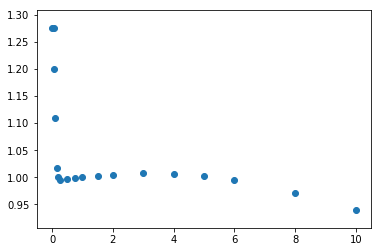

In [7]:
plt.scatter(
    radial_function_data.radius_cm,
    radial_function_data)

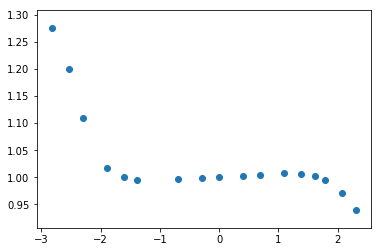

In [8]:
plt.scatter(
    np.log(radial_function_data.radius_cm[1::]),
    radial_function_data[1::])

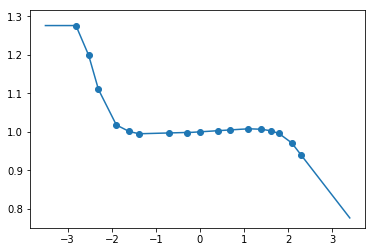

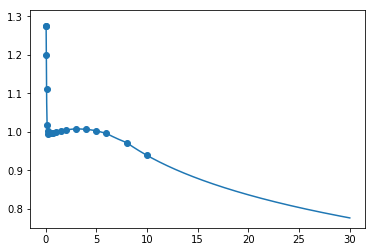

In [9]:
radial_function_interpolation = RegularGridInterpolator(
    (np.log(radial_function_data.radius_cm[1::]),),
    radial_function_data[1::],
    bounds_error=False,
    fill_value=None
)

def radial_function(radius):
    interpolation = radial_function_interpolation(np.log(radius))
    interpolation[radius < 0.06] = radial_function_data[0]
    return interpolation
    
r_test = np.linspace(0.03, 30, 10000)
y_test = radial_function(r_test)

plt.figure()
plt.scatter(
    np.log(radial_function_data.radius_cm[1::]),
    radial_function_data[1::])

plt.plot(
    np.log(r_test),
    y_test)

plt.figure()
plt.scatter(
    radial_function_data.radius_cm,
    radial_function_data)

plt.plot(
    r_test,
    y_test)

## Anisotropy function interpolation

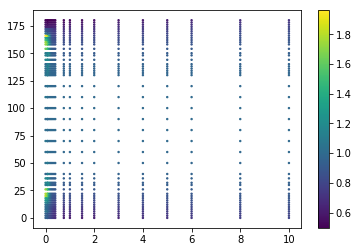

In [10]:
radius_cm_mesh, theta_deg_mesh = np.meshgrid(
    anisotropy_function_data.radius_cm,
    anisotropy_function_data.theta_deg)

plt.scatter(
    radius_cm_mesh,
    theta_deg_mesh,
    c=anisotropy_function_data,
    s=2)
plt.colorbar()

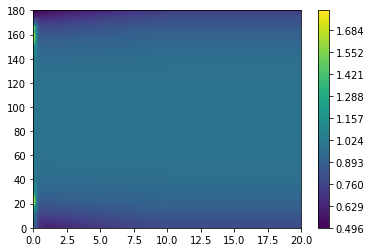

In [11]:
anisotropy_theta_deg = np.array(anisotropy_function_data.theta_deg)
anisotropy_radius_cm = np.array(anisotropy_function_data.radius_cm)

anisotropy_function_data_array = np.array(anisotropy_function_data)

anisotropy_function_linear_interpolation = RegularGridInterpolator(
    (anisotropy_theta_deg, anisotropy_radius_cm), anisotropy_function_data_array,
    bounds_error=False,
    fill_value=np.nan)

anisotropy_function_nearest_interpolation = RegularGridInterpolator(
    (anisotropy_theta_deg, anisotropy_radius_cm), anisotropy_function_data_array,
    bounds_error=False,
    fill_value=None,
    method='nearest')


def anisotropy_function(radius, theta):
    points = np.vstack([theta, radius]).T    
    linear_interpolation = anisotropy_function_linear_interpolation(points)
    
    ref = np.isnan(linear_interpolation)
    nearest_interpolation = anisotropy_function_nearest_interpolation(
        points[ref,:])
    
    linear_interpolation[ref] = nearest_interpolation
    
    return linear_interpolation


r_test = np.linspace(0, 20, 100)
theta_test = np.linspace(0, 180, 100)

r_test_mesh, theta_test_mesh = np.meshgrid(
    r_test, theta_test)

r_test_mesh_flat = r_test_mesh.ravel()
theta_test_mesh_flat = theta_test_mesh.ravel()

anisotropy_test = anisotropy_function(r_test_mesh_flat, theta_test_mesh_flat)

anisotropy_test = np.reshape(anisotropy_test, np.shape(r_test_mesh))

plt.contourf(r_test, theta_test, anisotropy_test, 1000)
plt.colorbar()

In [12]:
r_test_mesh, theta_test_mesh = np.meshgrid(
    anisotropy_radius_cm, anisotropy_theta_deg)

r_test_mesh_flat = r_test_mesh.ravel()
theta_test_mesh_flat = theta_test_mesh.ravel()

anisotropy_test = anisotropy_function(r_test_mesh_flat, theta_test_mesh_flat)
anisotropy_test = np.reshape(anisotropy_test, np.shape(r_test_mesh))

assert np.all(anisotropy_test - anisotropy_function_data_array == 0)

## Geometry Function

In [13]:
def calculate_beta(length, radius, theta):
    # http://jacmp.org/index.php/jacmp/article/viewFile/2615/1083
    theta2 = np.arctan(
        radius * np.sin(theta) / 
        (radius * np.cos(theta) - length/2))
    
    AP = radius * np.sin(theta)
    SA = radius * np.cos(theta) + length/2
    
    SP = np.sqrt(AP**2 + SA**2)
    
    beta = np.arcsin(
        length * np.sin(theta2) / 
        SP)
    
    return beta

def geometry_function(length, radius, theta):
    theta = theta / 180 * np.pi
    result = np.empty_like(radius)
    
    ref0 = (theta == 0) | (theta == np.pi)
    ref1 = (theta != 0) & (theta != np.pi)
    
    result[ref0] = (
        1 / (radius[ref0]**2 - length**2 / 4))
    
    beta = calculate_beta(
        length, radius[ref1], theta[ref1])
    result[ref1] = (
        beta / (length * radius[ref1] * np.sin(theta[ref1])))   
        
    return np.abs(result)

def normalised_geometry_function(length, radius, theta):
    geometry = geometry_function(length, radius, theta)
    ref = radius == 0
    geometry_0 = geometry_function(length, np.array([0.000001]*np.sum(ref)), theta[ref])
    
    geometry[ref] = geometry_0
    
    return (        
        geometry / 
        np.abs(calculate_beta(length, 1, np.pi/2) / length))

In [14]:
def tg43(radius, theta):
    initial_shape = np.shape(radius)
    radius_flat = np.ravel(radius)
    theta_flat = np.ravel(theta)
    
    geometry = normalised_geometry_function(length, radius_flat, theta_flat)
    radial = radial_function(radius_flat)
    anisotropy = anisotropy_function(radius_flat, theta_flat)
    
    result = dose_rate_constant * geometry * radial * anisotropy
    
    result = np.reshape(result, initial_shape)
    
    return result

In [15]:
def calc_on_grid(calc_grid_positions, dwell_positions, dwell_directions):
    
    calc_grid_vector = calc_grid_positions[:,None,:] - dwell_positions[None,:,:]
    
    radius = np.sqrt(
        calc_grid_vector[:,:,0]**2 + 
        calc_grid_vector[:,:,1]**2 +
        calc_grid_vector[:,:,2]**2)
    
    calc_unit_vector = calc_grid_vector / radius[:,:,None]
    dot_product = (
        dwell_directions[None,:,0] * calc_unit_vector[:,:,0] + 
        dwell_directions[None,:,1] * calc_unit_vector[:,:,1] + 
        dwell_directions[None,:,2] * calc_unit_vector[:,:,2])
    
    theta = np.arccos(dot_product) * 180 / np.pi
    nan_ref = np.isnan(theta)
    theta[nan_ref] = 90
    
    tg43_dose = tg43(radius, theta)
    
    return tg43_dose, radius

In [16]:
def determine_calc_grid_positions(calc_x, calc_y, calc_z):
    calc_x_mesh, calc_y_mesh, calc_z_mesh = np.meshgrid(
    calc_x, calc_y, calc_z)

    calc_x_mesh_flat = calc_x_mesh.ravel()
    calc_y_mesh_flat = calc_y_mesh.ravel()
    calc_z_mesh_flat = calc_z_mesh.ravel()

    calc_grid_positions = np.array([
        [calc_x_mesh_flat[i], calc_y_mesh_flat[i], calc_z_mesh_flat[i]]
        for i in range(len(calc_x_mesh_flat))
    ])
    
    return calc_grid_positions, np.shape(calc_x_mesh)

In [17]:
def tg43_on_grid(calc_x, calc_y, calc_z, 
                 reference_air_kerma_rate, dwell_times, dwell_positions, dwell_directions):
    calc_grid_positions, shape = determine_calc_grid_positions(
        calc_x, calc_y, calc_z)
    
    tg43_dose, radius = calc_on_grid(
        calc_grid_positions, dwell_positions, dwell_directions)
    
    total_dose = np.sum(
        tg43_dose * reference_air_kerma_rate * dwell_times[None, :], axis=1)
    
#     too_close = np.any(radius < length/2, axis=1)
#     total_dose[too_close] = np.nan
    
    total_dose = np.reshape(total_dose, shape)
    
    return total_dose

# Testing against QA along away

In [18]:
testing_calc_x = np.array(0)
testing_calc_y = np.array(QA_along_away_data.y_cm)
testing_calc_z = np.array(QA_along_away_data.z_cm)

test_reference_air_kerma_rate = 1
test_dwell_times = np.array([1])

testing_dwell_positions = np.array([[0, 0, 0]])
testing_dwell_directions = np.array([[0, 0, 1]])

testing_tg43_dose = tg43_on_grid(
    testing_calc_x, testing_calc_y, testing_calc_z, 
    test_reference_air_kerma_rate, test_dwell_times,
    testing_dwell_positions, testing_dwell_directions)

/home/simon/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide
/home/simon/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/simon/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/home/simon/anaconda3/lib/python3.5/site-packages/scipy/interpolate/interpolate.py:2382: RuntimeWarning: invalid value encountered in add
  values += np.asarray(self.values[edge_indices]) * weight[vslice]


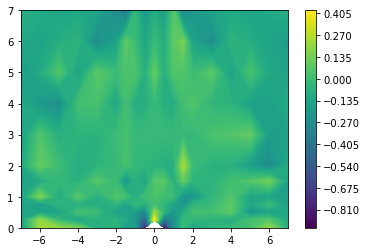

In [19]:
test_data = np.array(QA_along_away_data.T)
test_data[test_data > 1000] = np.nan

dose_difference = 100 * (testing_tg43_dose[:,0,:] - test_data) / test_data
plt.contourf(testing_calc_z, testing_calc_y, dose_difference, 1000)
plt.colorbar()

## Test on a patient dicom plan

In [20]:
import dicom
from glob import glob

from scipy.interpolate import splprep, splev, interp1d

dose_filename = glob("private/RD1*")[0]
plan_filename = glob("private/RP1*")[0]

### Load dicom files and retrieve required data

In [21]:
dcm_dose = dicom.read_file(dose_filename, force=True)
dcm_plan = dicom.read_file(plan_filename, force=True)

#### Reference Air Kerma Rate

In [22]:
reference_air_kerma_rate = np.float(dcm_plan.SourceSequence[0].ReferenceAirKermaRate) / 360000
reference_air_kerma_rate

0.12205361111111111

#### Dwell positions and dwell times

In [23]:
def pull_dwells(dcm):
    dwell_channels = []
    all_dwell_positions = []
    dwell_times = []

    number_of_channels = len(dcm.ApplicationSetupSequence[0].ChannelSequence)

    for i in range(number_of_channels):
        ChannelSequence = dcm.ApplicationSetupSequence[0].ChannelSequence[i]

        if len(ChannelSequence.dir("FinalCumulativeTimeWeight")) != 0:

            BrachyControlPointSequence = (
                ChannelSequence.BrachyControlPointSequence)
            number_of_dwells_in_channel = len(BrachyControlPointSequence)//2

            channel_time_weight = (
                    ChannelSequence.ChannelTotalTime / ChannelSequence.FinalCumulativeTimeWeight)

            channel_dwells_positions = []
            for j in range(0,number_of_dwells_in_channel*2,2):
                if len(BrachyControlPointSequence[j].dir("ControlPoint3DPosition")) != 0:
                    channel_dwells_positions.append(
                        BrachyControlPointSequence[j].ControlPoint3DPosition)
                    dwell_channels.append(i+1)

                    assert (
                        BrachyControlPointSequence[j].ControlPoint3DPosition == 
                        BrachyControlPointSequence[j+1].ControlPoint3DPosition
                    )
                    uncorrected_dwell_time = (
                        BrachyControlPointSequence[j+1].CumulativeTimeWeight - 
                        BrachyControlPointSequence[j].CumulativeTimeWeight
                    )
                    dwell_times.append(
                        uncorrected_dwell_time * channel_time_weight)

            all_dwell_positions += channel_dwells_positions

    dwell_channels = np.array(dwell_channels)
    dwell_positions = np.array(all_dwell_positions).astype(float) / 10
    dwell_times = np.array(dwell_times)
    
    return dwell_positions, dwell_channels, dwell_times

dwell_positions, dwell_channels, dwell_times = pull_dwells(dcm_plan)

#### Determine dwell directions

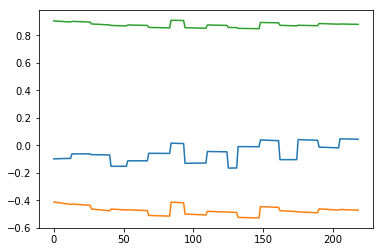

In [24]:
def pull_catheter_coords(dcm, channel):
    index = channel - 1
    catheter_coords = dcm[0x300f,0x1000][0].ROIContourSequence[index].ContourSequence[0].ContourData
    
    x = np.array(catheter_coords[0::3])
    y = np.array(catheter_coords[1::3])
    z = np.array(catheter_coords[2::3])
    
    return x, y, z


def determine_single_dwell_direction(dwell_position, dwell_channel):
    x, y, z = pull_catheter_coords(dcm_plan, dwell_channel)
    tckp, u = splprep([x,y,z], s=1, k=2, nest=-1)
#     tckp, u = splprep([x,y,z], s=0, k=1, nest=-1)  # Linear interp

    t = np.linspace(0,1,1000)
    x_spline, y_spline, z_spline = splev(t, tckp)    
    t_z = interp1d(z_spline, t)(dwell_position[2])
    
    derivative_vector = np.array(splev(t_z, tckp, der=1))
    forward_direction = derivative_vector / np.linalg.norm(derivative_vector)
    
    return forward_direction


def determine_dwell_directions(dwell_positions, dwell_channels):
    dwell_directions = np.array([
        determine_single_dwell_direction(dwell_positions[i], dwell_channels[i])
        for i in range(len(dwell_positions))
    ])
    
    return dwell_directions


dwell_directions = determine_dwell_directions(dwell_positions, dwell_channels)
plt.plot(dwell_directions)

### Load planning system dose and calc grid

In [25]:
# The x, y, and z defined here have not been sufficiently verified
# They do not necessarily match either what is within Dicom nor what is within your
# TPS. Please verify these and see if they are what you expect them to be.

# If these functions are incorrect or there is a better choice of dimension definitions 
# please contact me by creating an issue within the github repository:
#   https://github.com/SimonBiggs/npgamma/issues

# If you are able to validate these functions please contact me in the same way.


def load_dose_from_dicom(dcm):
    """Imports the dose in matplotlib format, with the following index mapping:
        i = y
        j = x
        k = z
    
    Therefore when using this function to have the coords match the same order,
    ie. coords_reference = (y, x, z)
    """
    pixels = np.transpose(
        dcm.pixel_array, (1, 2, 0))
    dose = pixels * dcm.DoseGridScaling

    return dose


def load_xyz_from_dicom(dcm):
    """Although this coordinate pull from Dicom works in the scenarios tested
    this is not an official x, y, z pull. It needs further confirmation.
    """
    resolution = np.array(
        dcm.PixelSpacing).astype(float)
    # Does the first index match x? 
    # Haven't tested with differing grid sizes in x and y directions.
    dx = resolution[0]

    # The use of dcm.Columns here is under question
    x = (
        dcm.ImagePositionPatient[0] +
        np.arange(0, dcm.Columns * dx, dx))

    # Does the second index match y? 
    # Haven't tested with differing grid sizes in x and y directions.
    dy = resolution[1]
    
    # The use of dcm.Rows here is under question
    y = (
        dcm.ImagePositionPatient[1] +
        np.arange(0, dcm.Rows * dy, dy))
    
    # Is this correct?
    z = (
        np.array(dcm.GridFrameOffsetVector) +
        dcm.ImagePositionPatient[2])

    return x, y, z

In [26]:
tps_dose = load_dose_from_dicom(dcm_dose)
max_dose = np.max(tps_dose)

max_dose_per_slice = np.max(np.max(tps_dose, axis=0), axis=0)
relevant_slice = max_dose_per_slice > max_dose * 0.1

In [27]:
x_raw, y_raw, z_raw = load_xyz_from_dicom(dcm_dose)

calc_grid_slice_skip = 2

calc_x = x_raw / 10
calc_y = y_raw / 10
calc_z = z_raw[relevant_slice] / 10
calc_z = calc_z[::calc_grid_slice_skip]

calc_grid_positions = determine_calc_grid_positions(calc_x, calc_y, calc_z)

In [28]:
tg43_dose = tg43_on_grid(
    calc_x, calc_y, calc_z, reference_air_kerma_rate, 
    dwell_times, dwell_positions, dwell_directions)

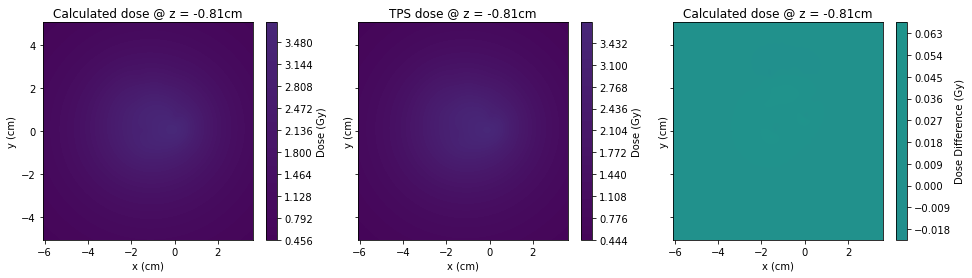

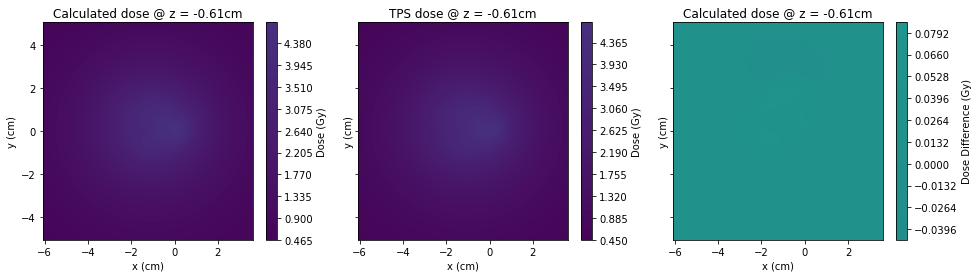

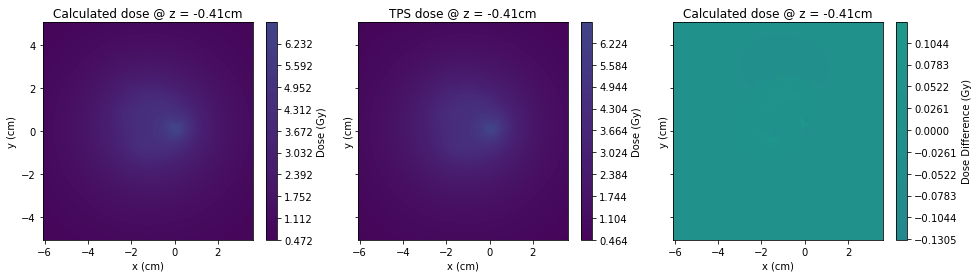

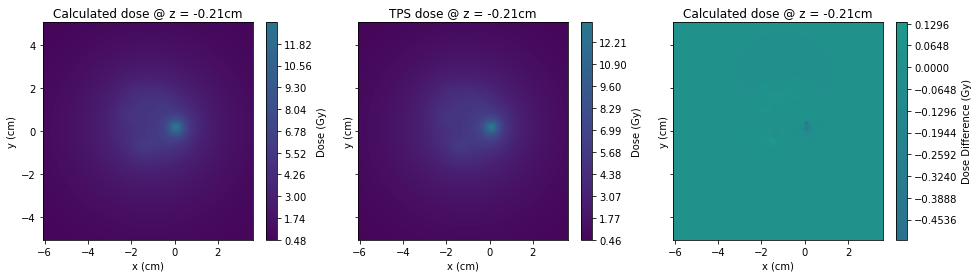

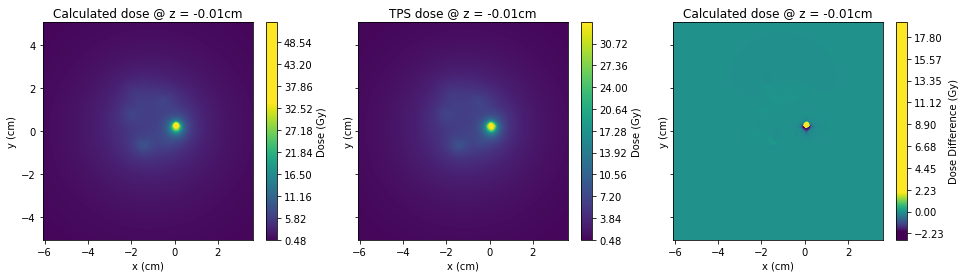

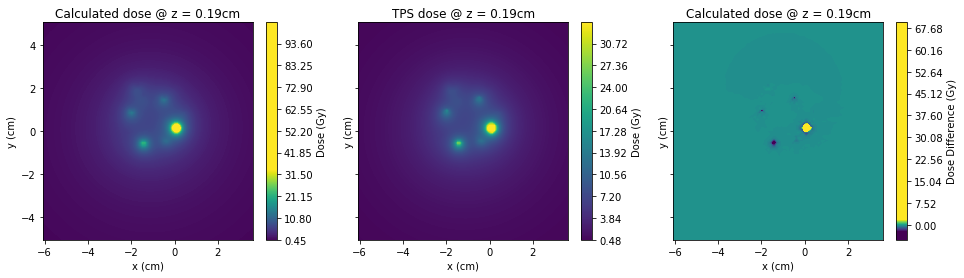

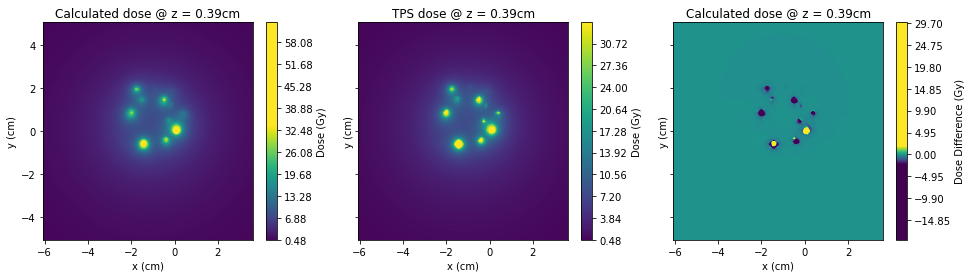

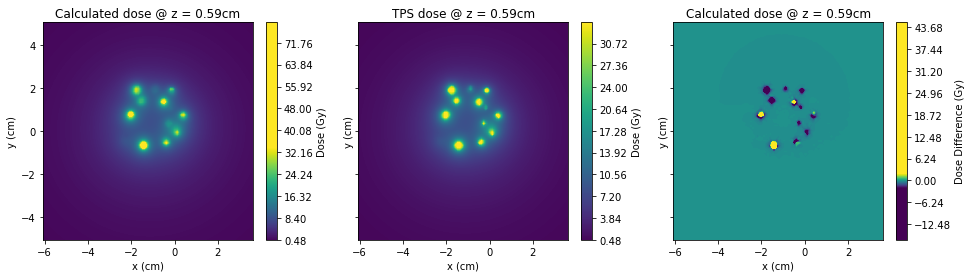

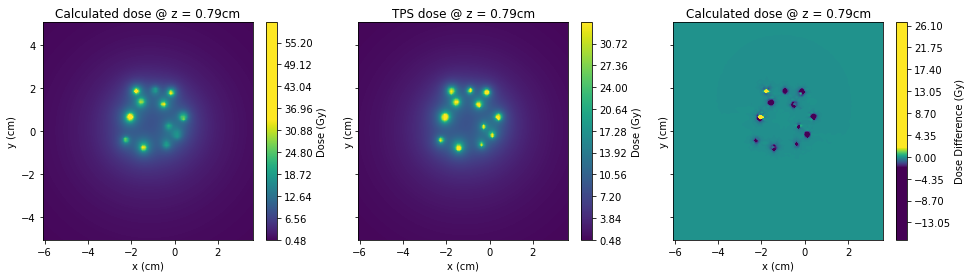

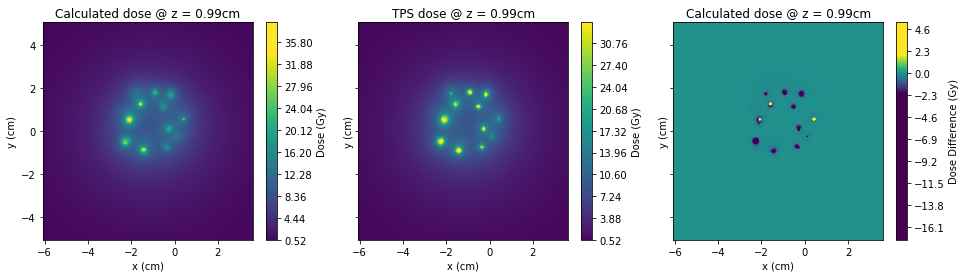

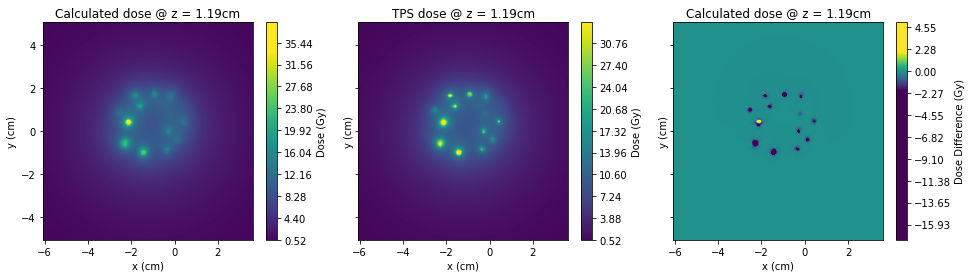

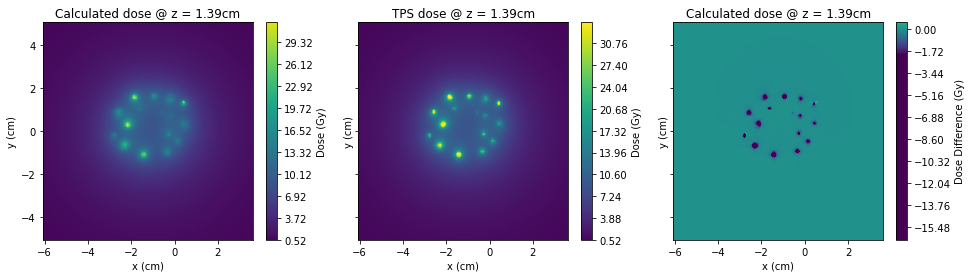

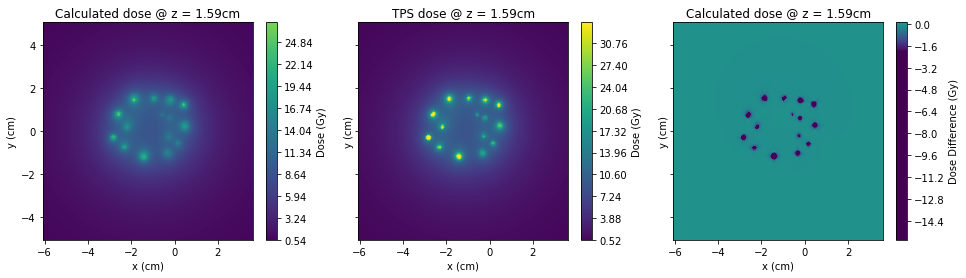

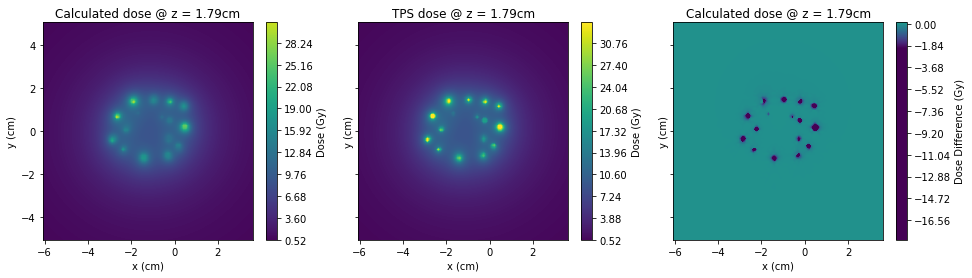

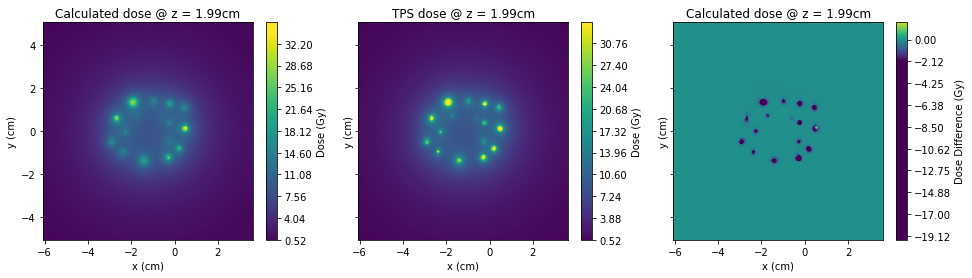

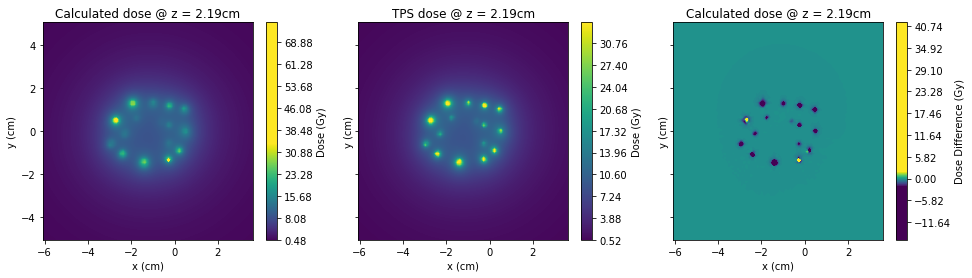

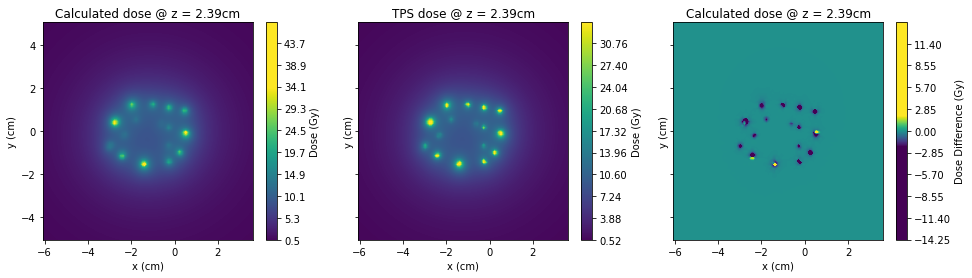

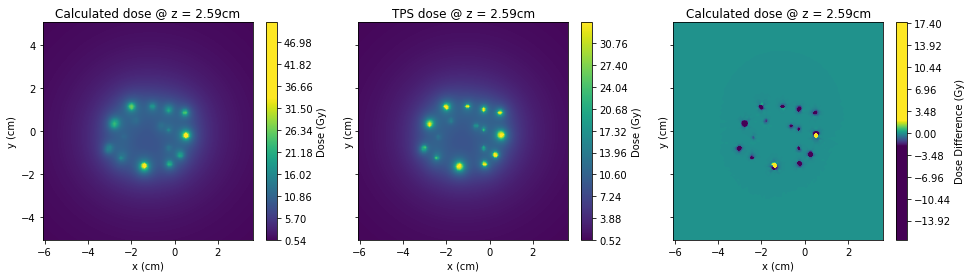

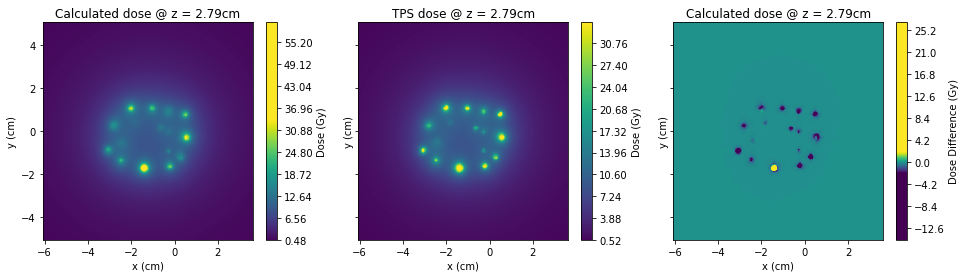

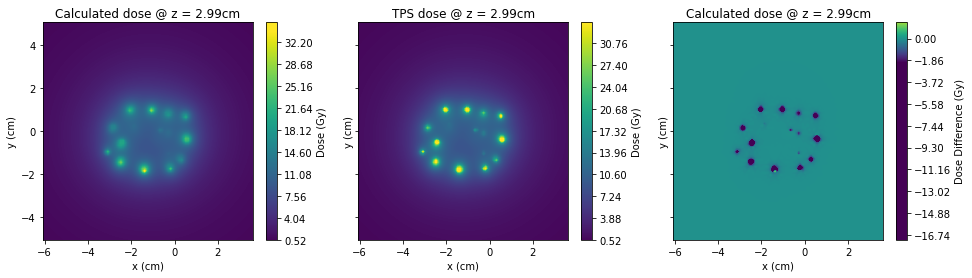

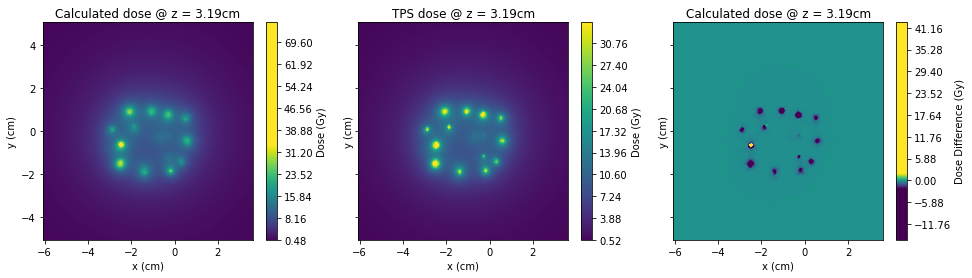

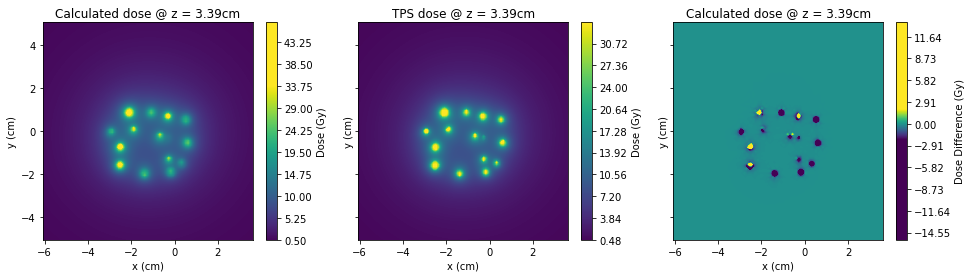

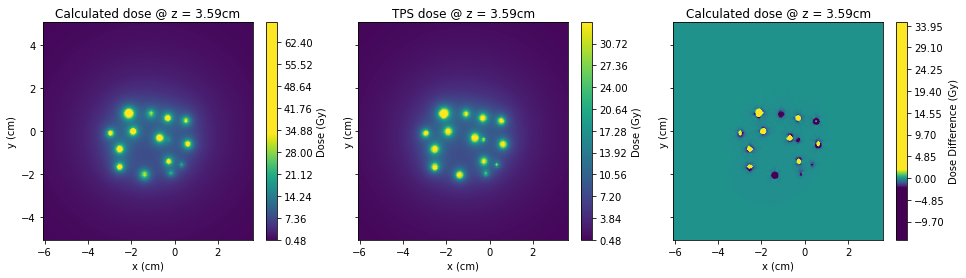

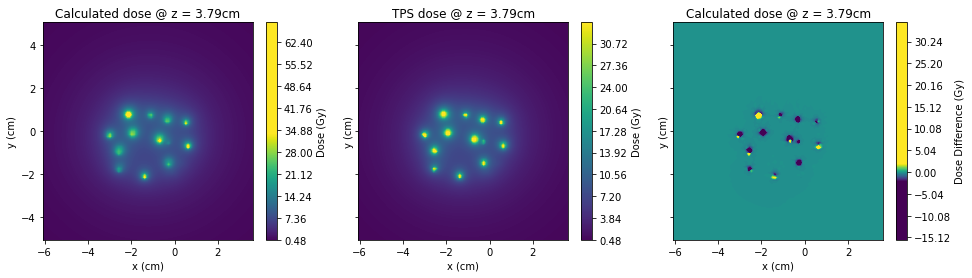

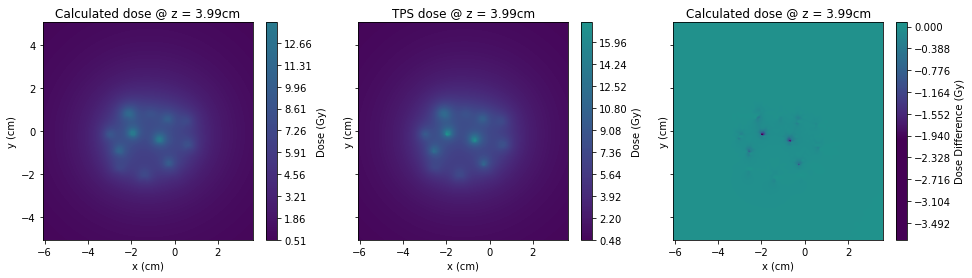

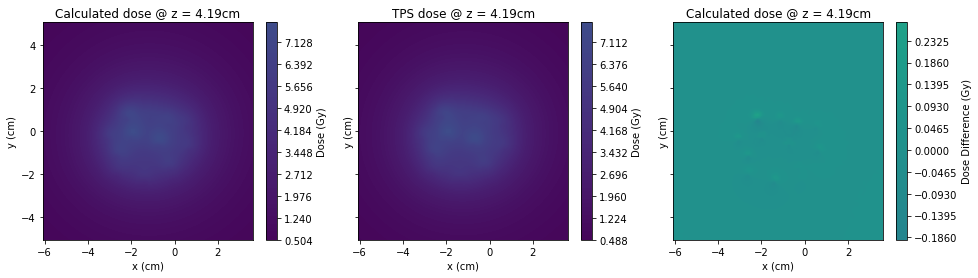

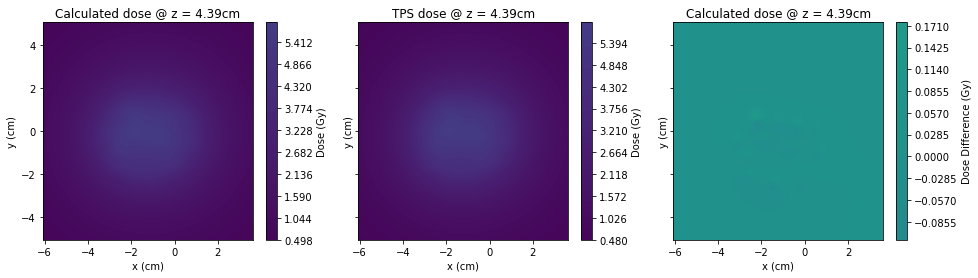

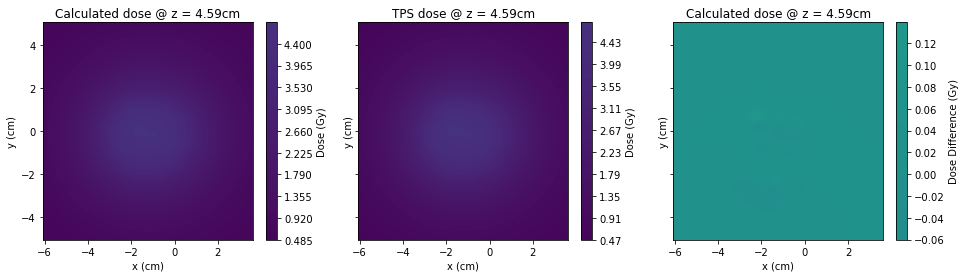

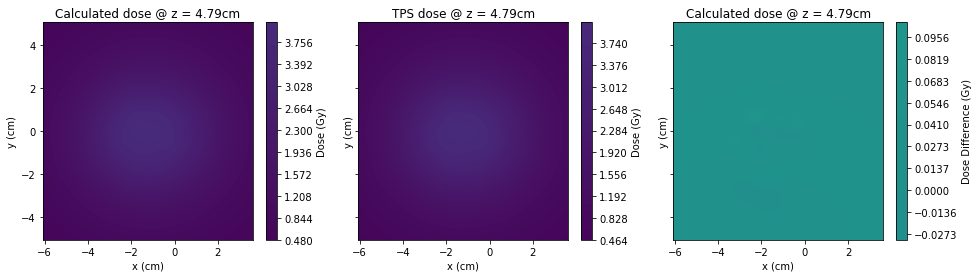

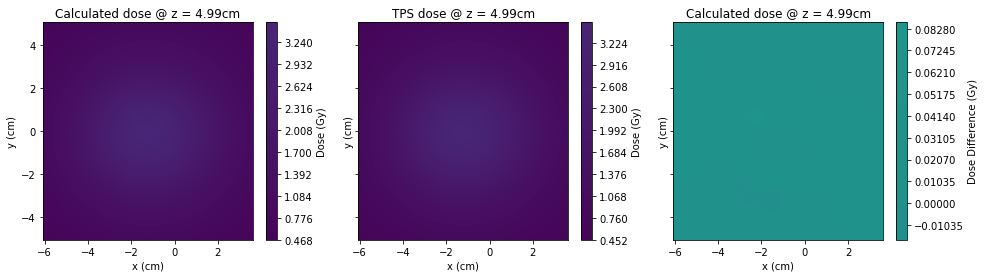

In [29]:
for z in calc_z:
    tps_z_ref = np.where(z_raw/10 == z)[0][0]
    calc_z_ref = np.where(calc_z == z)[0][0]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(16,4))
    
    c1 = ax1.contourf(
        calc_x, calc_y, tg43_dose[:,:,calc_z_ref], 1000, vmin=0, vmax=max_dose)
    ax1.set_title("Calculated dose @ z = {0:.2f}cm".format(z))
    ax1.set_xlabel("x (cm)")
    ax1.set_ylabel("y (cm)")
    
    cbar = plt.colorbar(c1, ax=ax1)
    cbar.ax.set_ylabel('Dose (Gy)')
    
    
    c2 = ax2.contourf(
        calc_x, calc_y, tps_dose[:,:,tps_z_ref], 1000, vmin=0, vmax=max_dose)
    ax2.set_title("TPS dose @ z = {0:.2f}cm".format(z))
    ax2.set_xlabel("x (cm)")
    ax2.set_ylabel("y (cm)")
    
    cbar = plt.colorbar(c2, ax=ax2)
    cbar.ax.set_ylabel('Dose (Gy)')
    
    dose_diff = tg43_dose[:,:,calc_z_ref] - tps_dose[:,:,tps_z_ref]
    
    c3 = ax3.contourf(
        calc_x, calc_y, dose_diff, 1000, vmin=-2, vmax=2)
    ax3.set_title("Calculated dose @ z = {0:.2f}cm".format(z))
    ax3.set_xlabel("x (cm)")
    ax3.set_ylabel("y (cm)")
    
    cbar = plt.colorbar(c3, ax=ax3)
    cbar.ax.set_ylabel('Dose Difference (Gy)')
    
    plt.show()